In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(2)

# Importing the data and simulations


In [ ]:
# Create a dataframe for the measurements
measurements = pd.read_csv("/content/drive/My Drive/atlas/data.csv")


measurements

,InvMassZ1_min,InvMassZ2_min,FourLepSystem_pt,FourLepSystem_y,FourLepSystem_M,FourLepSystem_M_ext,goodjet_n,Lepton1_pt_GeV,Lepton1_eta,Lepton1_E_GeV,...,Lepton3_phi,Lepton3_charge,Lepton3_type,Lepton4_pt_GeV,Lepton4_eta,Lepton4_E_GeV,Lepton4_phi,Lepton4_charge,Lepton4_type,weight
0,90.3102,83.73790,3.16055,1.465470,649.2720,649.2720,0,175.5590,2.076850,711.4210,...,-1.797010,-1,13,79.77670,2.398580,442.6960,0.587067,1,11,1
1,68.2123,3.15921,97.41060,0.369990,87.9071,87.9071,1,65.2841,0.103152,65.6317,...,2.223430,-1,13,8.80456,1.115100,14.8702,2.496740,1,13,1
2,111.8860,131.69800,13.13640,-0.170268,344.7760,344.7760,0,146.7850,-0.201372,149.7710,...,2.001550,-1,11,29.77610,0.477603,33.2372,2.971450,-1,11,1
3,92.1070,77.17910,114.74300,1.127310,326.5840,326.5840,1,135.6810,1.491340,316.6860,...,2.271930,1,11,42.55290,0.575527,49.7971,-1.122610,1,13,1
4,89.8856,101.51400,40.54240,-0.666253,574.6420,574.6420,1,133.9970,-0.352875,142.4270,...,-1.089430,1,13,95.29190,0.187900,96.9791,1.507790,-1,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,97.4430,12.32910,13.51480,-0.188801,221.0810,221.0810,0,63.1552,-0.855442,87.7070,...,0.694196,-1,11,17.94190,0.602650,21.3001,2.064400,1,13,1
317,97.1690,102.20800,40.82760,-0.784744,209.5850,209.5850,0,51.7734,-1.286350,100.8500,...,-1.418480,1,11,30.73760,0.303122,32.1606,2.381360,-1,11,1
318,85.8210,24.72010,59.83970,-0.265105,121.2700,121.2700,1,61.5618,-0.656188,75.2981,...,0.068401,-1,13,14.41100,-0.214533,14.7443,2.700490,1,13,1
319,95.8891,159.35900,66.71950,1.452570,318.5950,318.5950,0,114.0720,1.667800,313.0790,...,-0.932569,-1,11,26.18040,1.285180,50.9460,-1.999640,-1,11,1


In [ ]:
import glob
import os
import pandas as pd

# Get all the different csv files
csv_dir = "/content/drive/My Drive/atlas/"
csv_files = glob.glob(f"{csv_dir}*.csv")


# Create empty lists to store the different dataframes
signal_df = []
bkg_df = []

# Get the parameter information from the document
info = pd.read_csv("/content/drive/My Drive/atlas/Files_HZZ.txt", delimiter='|')

for f in csv_files:
    if os.path.basename(f) == "data.csv": # We do nothing to the data
        continue

    data_frame = pd.read_csv(f, delimiter=',')

    filename = os.path.basename(f)
    dataset_name = os.path.splitext(filename)[0]

    index = info[info['### name '] == dataset_name].index[0]

    # Retrieve information needed to calculate scaling factor
    cross = info[' cross-section '][index]
    sum_weight = info[' sum of weights '][index]
    efficiency = info[' efficiency'][index]

    # Calculate the scaling factor and scale weights accordingly
    scale_factor = cross * efficiency * 10064 / sum_weight
    data_frame['weight'] *= scale_factor

    # Every title containing H125 is signal, the rest is background
    if 'H125' in dataset_name:
        signal_df.append(data_frame)
    else:
        bkg_df.append(data_frame)

signal = pd.concat(signal_df, ignore_index=True)
bkg   = pd.concat(bkg_df,    ignore_index=True)
signal

<ipython-input-5-3109273662>:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bkg   = pd.concat(bkg_df,    ignore_index=True)


,InvMassZ1_min,InvMassZ2_min,FourLepSystem_pt,FourLepSystem_y,FourLepSystem_M,FourLepSystem_M_ext,goodjet_n,Lepton1_pt_GeV,Lepton1_eta,Lepton1_E_GeV,...,Lepton3_phi,Lepton3_charge,Lepton3_type,Lepton4_pt_GeV,Lepton4_eta,Lepton4_E_GeV,Lepton4_phi,Lepton4_charge,Lepton4_type,weight
0,25.4937,9.95380,2.43944,-0.740729,122.689,122.689,0,51.9055,-0.925709,75.7796,...,0.244079,1,13,7.47123,0.266718,7.73927,-2.495820,-1,13,0.000018
1,49.4294,38.82190,8.06714,-0.744767,113.659,113.659,0,41.4306,-1.233180,77.1335,...,1.464690,-1,13,7.48186,-0.302179,7.82677,-2.957070,1,13,0.000034
2,62.6274,32.12280,1.53598,0.393632,125.400,125.400,0,33.6467,-0.032324,33.6645,...,0.691143,1,11,16.47260,1.859530,54.16600,-0.358869,-1,13,0.000040
3,84.5351,29.14370,107.02700,0.815818,123.645,123.645,1,77.1186,0.514764,87.5638,...,1.537910,1,13,14.71450,0.179711,14.95280,2.122280,1,11,0.000060
4,68.9581,48.50080,244.49200,-0.916990,123.518,123.518,1,161.9090,-1.037350,257.1220,...,-0.953228,1,11,18.86450,0.126195,19.01490,0.046575,-1,11,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320574,88.2999,30.36930,78.44770,-0.971566,124.296,124.296,1,46.0217,-0.381443,49.4107,...,-0.083267,-1,11,13.80460,-1.129850,23.59380,-1.721110,1,11,0.000005
320575,48.6785,8.00488,9.64885,-0.889902,128.302,128.302,0,38.9844,-0.407494,42.2661,...,-2.771020,-1,11,13.18120,-0.587269,15.52030,-0.212472,-1,11,0.000005
320576,70.1526,20.79020,3.18158,-1.288360,125.384,125.384,0,49.2385,-1.167530,86.7876,...,0.089630,-1,11,18.88080,-1.114020,31.85960,1.056970,1,11,0.000000
320577,58.1199,52.95760,98.82350,-0.225322,121.489,121.489,2,51.6124,-0.844507,71.1373,...,1.440520,1,11,7.75420,1.148500,13.45580,0.752648,1,11,0.000002


In [ ]:
# Label the data and put it in one big dataframe
signal['label'] = 1
bkg['label']    = 0

# Concatenate all the samples
data = pd.concat([signal,bkg],ignore_index=True)

In [ ]:
features = data.columns
features

Index(['InvMassZ1_min', 'InvMassZ2_min', 'FourLepSystem_pt', 'FourLepSystem_y',
       'FourLepSystem_M', 'FourLepSystem_M_ext', 'goodjet_n', 'Lepton1_pt_GeV',
       'Lepton1_eta', 'Lepton1_E_GeV', 'Lepton1_phi', 'Lepton1_charge',
       'Lepton1_type', 'Lepton2_pt_GeV', 'Lepton2_eta', 'Lepton2_E_GeV',
       'Lepton2_phi', 'Lepton2_charge', 'Lepton2_type', 'Lepton3_pt_GeV',
       'Lepton3_eta', 'Lepton3_E_GeV', 'Lepton3_phi', 'Lepton3_charge',
       'Lepton3_type', 'Lepton4_pt_GeV', 'Lepton4_eta', 'Lepton4_E_GeV',
       'Lepton4_phi', 'Lepton4_charge', 'Lepton4_type', 'weight', 'label'],
      dtype='object')

In [ ]:
# Uncomment this cell to plot the histograms for each variable
# plot_features = ['InvMassZ1_min', 'InvMassZ2_min', 'FourLepSystem_pt', 'FourLepSystem_y',
#        'FourLepSystem_M', 'FourLepSystem_M_ext', 'goodjet_n', 'Lepton1_pt_GeV',
#        'Lepton1_eta', 'Lepton1_E_GeV', 'Lepton1_phi', 'Lepton1_charge',
#        'Lepton1_type', 'Lepton2_pt_GeV', 'Lepton2_eta', 'Lepton2_E_GeV',
#        'Lepton2_phi', 'Lepton2_charge', 'Lepton2_type', 'Lepton3_pt_GeV',
#        'Lepton3_eta', 'Lepton3_E_GeV', 'Lepton3_phi', 'Lepton3_charge',
#        'Lepton3_type', 'Lepton4_pt_GeV', 'Lepton4_eta', 'Lepton4_E_GeV',
#        'Lepton4_phi', 'Lepton4_charge', 'Lepton4_type']

# for feat in plot_features:
#     bins = plt.hist(measurements[feat].values, bins=20, density=True, histtype='step', color='black', label='data')
#     plt.hist(signal[feat].values, bins=bins[1], density=True, histtype='step', color='red', label='signal')
#     plt.hist(bkg[feat].values, bins=bins[1], density=True, histtype='step', color='blue', label='background')
#     plt.xlabel(feat)
#     plt.ylabel('Density \(a.u\)')
#     plt.legend()
#     #plt.yscale("log")
#     plt.show()

# Data pre-processing for training


In [ ]:
# Define the training features. We are selecting all features except for FourLepSystem_M to avoid biasing the data
train_features = ['InvMassZ1_min', 'InvMassZ2_min', 'FourLepSystem_pt', 'FourLepSystem_y',
        'FourLepSystem_M_ext', 'goodjet_n', 'Lepton1_pt_GeV',
       'Lepton1_eta', 'Lepton1_E_GeV', 'Lepton1_phi', 'Lepton1_charge',
       'Lepton1_type', 'Lepton2_pt_GeV', 'Lepton2_eta', 'Lepton2_E_GeV',
       'Lepton2_phi', 'Lepton2_charge', 'Lepton2_type', 'Lepton3_pt_GeV',
       'Lepton3_eta', 'Lepton3_E_GeV', 'Lepton3_phi', 'Lepton3_charge',
       'Lepton3_type', 'Lepton4_pt_GeV', 'Lepton4_eta', 'Lepton4_E_GeV',
       'Lepton4_phi', 'Lepton4_charge', 'Lepton4_type']

In [ ]:
# Define training weights such that signal:bkg is 1:1

data['train_weight'] = 1

data.loc[data.query('label==1').index,'train_weight'] = data.loc[data.query('label==1').index,'train_weight'] \
                                                      / data.loc[data.query('label==1').index,'train_weight'].sum()
data.loc[data.query('label==0').index,'train_weight'] = data.loc[data.query('label==0').index,'train_weight'] \
                                                      / data.loc[data.query('label==0').index,'train_weight'].sum()

sum_w_sig = data.query('label==0')['train_weight'].sum()
sum_w_bkg = data.query('label==1')['train_weight'].sum()
print(f'Sum of weights for training Signal {sum_w_sig:.3} and Background {sum_w_bkg:.3}')

<ipython-input-10-1909967983>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.11935592e-06 3.11935592e-06 3.11935592e-06 ... 3.11935592e-06
 3.11935592e-06 3.11935592e-06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data.query('label==1').index,'train_weight'] = data.loc[data.query('label==1').index,'train_weight'] \


Sum of weights for training Signal 1.0 and Background 1.0


In [ ]:
# We split the data into train, validation and test data using the train_test_split feature from sklearn
print(f'Data sample x {len(data)} events\n')
x_train,x_val,y_train,y_val,w_train,w_val = train_test_split(data[train_features].values,data['label'].values,
                                                             data['train_weight'].values,train_size=1/3,random_state=9)
print(f'1st split Train sample x {len(x_train)} events (y {len(y_train)} events)')
print(f'1st split Val   sample x {len(x_val)} events (y {len(y_val)} events)\n')

x_val,x_test,y_val,y_test,w_val,w_test = train_test_split(x_val,y_val,w_val,test_size=1/2,random_state=9)
print(f'2nd split Train sample x {len(x_train)} events (y {len(y_train)} events)')
print(f'2nd split Val   sample x {len(x_val)} events (y {len(y_val)} events)')
print(f'2nd split Test  sample x {len(x_test)} events (y {len(y_test)} events)')

Data sample x 777476 events

1st split Train sample x 259158 events (y 259158 events)
1st split Val   sample x 518318 events (y 518318 events)



KeyboardInterrupt: 

# Define the DNN


In [ ]:
model = Sequential()

# The Input Layer
model.add(Dense(200, input_dim = x_train.shape[1], activation='relu'))

# The Hidden Layers
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))

# The Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the network
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), weighted_metrics=['accuracy'])
model.summary()

# Train the DNN


In [ ]:
# Train the DNN (this takes approx 8 mins)

# Ensure that all parameters are in the right format
x_train = np.asarray(x_train).astype(np.float32)
x_val   = np.asarray(x_val).astype(np.float32)
x_test  = np.asarray(x_test).astype(np.float32)


history = model.fit(x_train, y_train, sample_weight=w_train, validation_data=(x_val,y_val,w_val),
                       epochs=200, batch_size=1024, callbacks=EarlyStopping(patience=15),verbose=0)


# Evaluate the DNN


In [ ]:
# Plot the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
# Predict signal probabilities for test data
y_test_pred = model.predict(x_test)

# Calculate the AUC for this model
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

fprtrain, tprtrain, _ = roc_curve(y_train, y_train_pred)
fprval, tprval, _ = roc_curve(y_val, y_val_pred)
trainauc = roc_auc_score(y_train, y_train_pred)
valauc = roc_auc_score(y_val, y_val_pred)
print(trainauc, valauc)

In [ ]:
# Run this cell to run with standardized data (9 minutes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_val_std = scaler.transform(x_val)
history = model.fit(x_train_std, y_train, sample_weight=w_train, validation_data=(x_val_std,y_val,w_val),
                    epochs=200, batch_size=1024, callbacks=[EarlyStopping(patience=15)], verbose=0)

y_train_pred = model.predict(x_train_std)
y_val_pred = model.predict(x_val_std)

fprtrain, tprtrain, _ = roc_curve(y_train, y_train_pred)
fprval, tprval, _ = roc_curve(y_val, y_val_pred)

trainauc = roc_auc_score(y_train, y_train_pred)
valauc = roc_auc_score(y_val, y_val_pred)

print(trainauc, valauc)


In [ ]:
# Plot the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# Apply the model to the measurements


Now that we have seen that this model works and can classify signal and background, we can apply the model to the measurements


In [ ]:
# Extract the same features as for training
x_measurements = measurements[train_features].values.astype(np.float32)
# Predict signal probability (if you used standardized data)
x_measurements_std = scaler.transform(x_measurements)
measurement_pred = model.predict(x_measurements_std)
measurement_class = (measurement_pred > 0.5).astype(int)

# Predict signal probability (if you did not used standardized data)
# measurement_pred = model.predict(x_measurements)
# measurement_class = (measurement_pred > 0.5).astype(int)

# Store predictions in your dataframe
measurements['signal_prob'] = measurement_pred
measurements['signal_class'] = measurement_class

In [ ]:
plt.hist(y_test_pred, bins=50, weight=w_test, alpha=0.7, label='Test Predictions')
plt.xlabel("Signal Probability")
plt.ylabel("Number of Events")
plt.legend()
plt.show()

In [ ]:
plt.hist(measurement_pred, bins=50, alpha=0.7, label='Measurement Predictions')
plt.xlabel("Signal Probability")
plt.ylabel("Number of Events")
plt.legend()
plt.show()

In [ ]:
#Split by predicted class
measurements_bkg = measurements[measurements['signal_class'] == 0]
measurements_sig = measurements[measurements['signal_class'] == 1]

#Plot histogram of FourLepSystem_M
plt.figure(figsize=(10, 5))
plt.hist([measurements_bkg['FourLepSystem_M'], measurements_sig['FourLepSystem_M']],
         bins=30, range=(80, 170), stacked=True,
         label=['Predicted Background', 'Predicted Signal'],
         color=['black', 'red'], alpha=0.7)
plt.hist(measurements['FourLepSystem_M'], bins=30, range=(80, 170),
         alpha=0.7, label='Measurement', color='green', histtype='step')

plt.xlabel('FourLepSystem_M')
plt.ylabel('Number of Events')
plt.title('Model Prediction on Real Data: Signal vs Background')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Fitting simulation to data via pyhf
- fit on FourLepSystem_M
- create a model for pyhf
- fit model onto the real data
- get best fit parameters

In [ ]:
!pip install pyhf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
## prepare signal, background and data

import pyhf
import scipy.stats as stats

# Observable for the fit
observable_name = 'FourLepSystem_M'

# Use already loaded signal, background, and measurement DataFrames
signal_obs = signal[observable_name].values
bkg_obs = bkg[observable_name].values
data_obs = measurements[observable_name].values

# Extract weights
signal_weights = signal['weight'].values
bkg_weights = bkg['weight'].values

print(f"\nObservable range - Signal: [{signal_obs.min():.1f}, {signal_obs.max():.1f}]")
print(f"Observable range - Background: [{bkg_obs.min():.1f}, {bkg_obs.max():.1f}]")
print(f"Observable range - Data: [{data_obs.min():.1f}, {data_obs.max():.1f}]")


Observable range - Signal: [40.2, 838.9]
Observable range - Background: [21.1, 3250.8]
Observable range - Data: [82.6, 910.8]


### Pre-fit plot


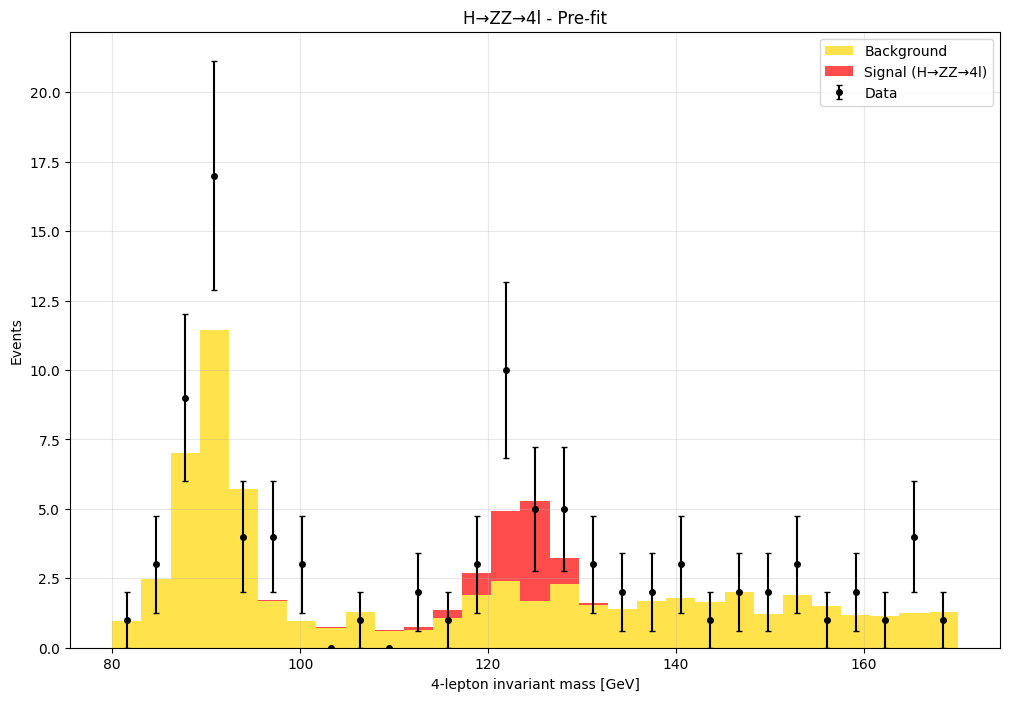

In [ ]:
# Define bins for the analysis
bins = np.linspace(80, 170, 30)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create weighted histograms
signal_hist, _ = np.histogram(signal_obs, bins=bins, weights=signal_weights)
bkg_hist, _ = np.histogram(bkg_obs, bins=bins, weights=bkg_weights)
data_hist, _ = np.histogram(data_obs, bins=bins)

# Plot pre-fit distribution
plt.figure(figsize=(12, 8))
plt.hist(bins[:-1], bins, weights=bkg_hist, histtype='bar', alpha=0.7, color='gold', label='Background')
plt.hist(bins[:-1], bins, weights=signal_hist, histtype='bar', alpha=0.7, color='red', bottom=bkg_hist, label='Signal (H→ZZ→4l)')
data_errors = np.sqrt(data_hist)
plt.errorbar(bin_centers, data_hist, yerr=data_errors, color='black', fmt='o', capsize=2, label='Data', markersize=4)
plt.xlabel('4-lepton invariant mass [GeV]')
plt.ylabel('Events')
plt.legend()
plt.title('H→ZZ→4l - Pre-fit')
plt.grid(True, alpha=0.3)
plt.show()

### Create Pyhf Model

In [ ]:
# Create pyhf model
model_spec = {
    'channels': [{
        'name': 'HZZ4lep',
        'samples': [{'name': 'signal','data': signal_hist.tolist(),'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
                    {'name': 'background','data': bkg_hist.tolist(),'modifiers': [
                    {'name': 'bkg_sys','type': 'normsys','data': {'hi': 1.1,'lo': 0.9}}
                ]
            }
        ]
    }],
    'observations': [{'name': 'HZZ4lep', 'data': data_hist.tolist()}],
    'measurements': [{'name': 'Measurement', 'config': {'poi': 'mu', 'parameters': []}}],
    'version': '1.0.0'
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()
data_for_fit = data_hist.tolist() + model.config.auxdata

def z_value(CL_b):
    return abs(stats.norm.isf(CL_b))


### Discovery Fit

In [ ]:
CLb_obs, _, CLb_exp = pyhf.infer.hypotest(0.0, data_for_fit, model, test_stat="q0", return_tail_probs=True, return_expected=True)
print(f"Observed significance: {z_value(CLb_obs):.3f}σ")
print(f"Expected significance: {z_value(CLb_exp):.3f}σ")

# Best-fit parameters
best_pars = pyhf.infer.mle.fit(data=data_for_fit, pdf=model)
print(f"Best-fit μ: {best_pars[0]:.3f}")
bkg_norm_best = best_pars[1]
print(f"Best-fit background normalization: {bkg_norm_best:.3f}")

Observed significance: 3.736σ
Expected significance: 2.558σ
Best-fit μ: 1.658
Best-fit background normalization: 1.115


### Exclusion Fit

In [ ]:
poi_values = np.linspace(0.1, 5.0, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upper_limits.upper_limit(data_for_fit, model, poi_values, level=0.05)
print(f"Observed μ upper limit (95% CL): {obs_limit:.3f}")
print(f"Expected μ upper limit (95% CL): {exp_limits[2]:.3f}")

Observed μ upper limit (95% CL): 2.761
Expected μ upper limit (95% CL): 0.863


### Post-Fit plot

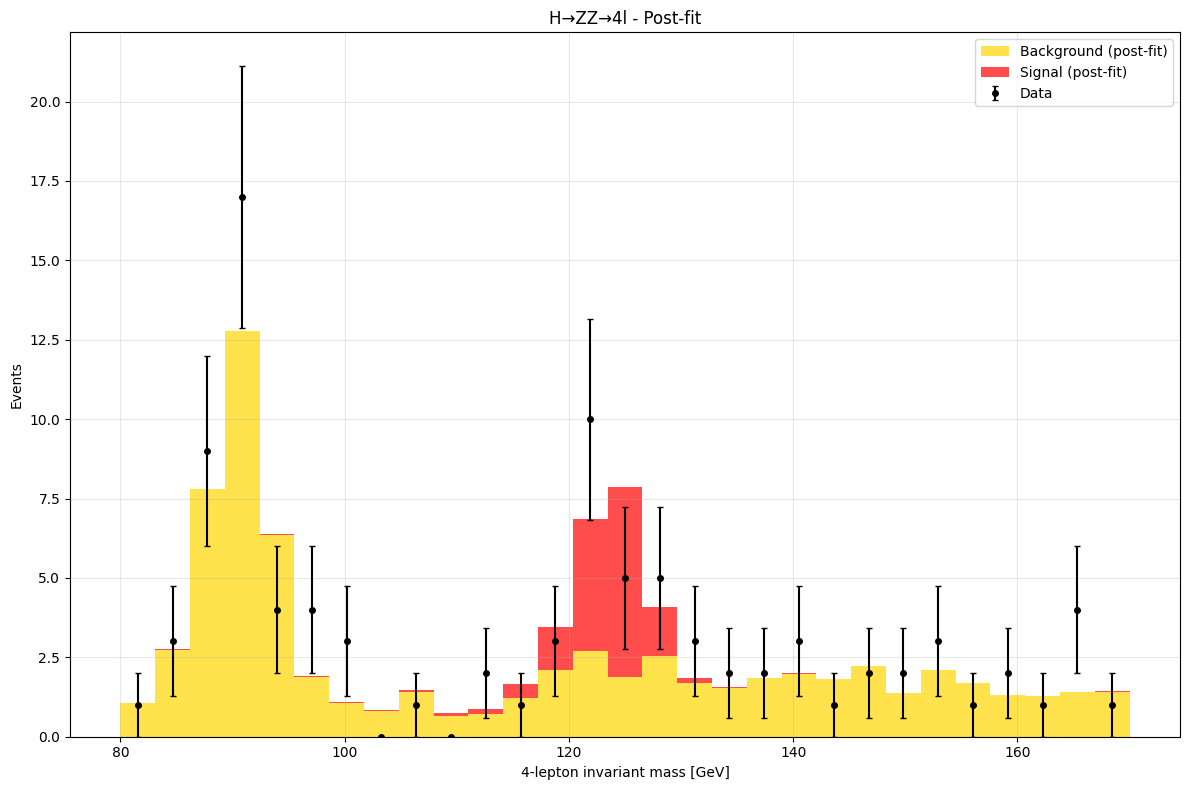

ANALYSIS SUMMARY:
Best fit signal strength: μ = 1.658
Discovery significance: 3.74σ (observed), 2.56σ (expected)
95% CL upper limit: μ < 2.761 (observed), μ < 0.863 (expected)
It's evidence as the significance > 3σ


In [ ]:
signal_postfit = signal_hist * best_pars[0]
bkg_postfit = bkg_hist * best_pars[1] if len(best_pars) > 1 else bkg_hist

plt.figure(figsize=(12, 8))
plt.hist(bins[:-1], bins, weights=bkg_postfit, histtype='bar', alpha=0.7, color='gold', label='Background (post-fit)')
plt.hist(bins[:-1], bins, weights=signal_postfit, histtype='bar', alpha=0.7, color='red', bottom=bkg_postfit, label='Signal (post-fit)')
plt.errorbar(bin_centers, data_hist, yerr=data_errors, color='black', fmt='o', capsize=2, label='Data', markersize=4)
plt.xlabel('4-lepton invariant mass [GeV]')
plt.ylabel('Events')
plt.title('H→ZZ→4l - Post-fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



print("ANALYSIS SUMMARY:")
print(f"Best fit signal strength: μ = {best_pars[0]:.3f}")
print(f"Discovery significance: {z_value(CLb_obs):.2f}σ (observed), {z_value(CLb_exp):.2f}σ (expected)")
print(f"95% CL upper limit: μ < {obs_limit:.3f} (observed), μ < {exp_limits[2]:.3f} (expected)")

if z_value(CLb_obs) > 5.0:
    print("It's a discovery as the significance > 5σ")
elif z_value(CLb_obs) > 3.0:
    print("It's evidence as the significance > 3σ")
else:
    print("Not a big enough significance for evidence or discovery")

## Pyhf on the Mask from Machine Learning
- we will use the mask derived from machine learning on signal and bkg
- then use pyhf again to calculate the statistics

### Mask from machine learning

In [ ]:
# Define the region in which we are going to search for the signal using the machine learning output
mask = (bins[:-1] >= np.min(measurements_sig['FourLepSystem_M'])) & (bins[:-1] < np.max(measurements_sig['FourLepSystem_M']))

In [ ]:
signal_hist_macbin= signal_hist[mask]
bkg_hist_macbin= bkg_hist[mask]
data_hist_macbin = data_hist[mask]

masked_bin_edges = bins[:-1][mask]
masked_bin_right_edges = bins[1:][mask]
masked_bin_centers = 0.5 * (masked_bin_edges + masked_bin_right_edges)
masked_bin_widths = masked_bin_right_edges - masked_bin_edges

### pre-fit plot

In [ ]:
# Plot pre-fit distribution
plt.figure(figsize=(12, 8))
plt.bar(
    masked_bin_centers,
    bkg_hist_macbin,
    width=masked_bin_widths,
    alpha=0.7,
    color='gold',
    label='Background',
    align='center'
)
plt.bar(
    masked_bin_centers,
    signal_hist_macbin,
    width=masked_bin_widths,
    alpha=0.7,
    color='red',
    label='Signal (H→ZZ→4l)',
    align='center'
)

data_errors = np.sqrt(data_hist_macbin)
plt.errorbar(
    masked_bin_centers,
    data_hist_macbin,
    yerr=data_errors,
    color='black',
    fmt='o',
    capsize=2,
    label='Data',
    markersize=4
)
plt.xlabel('4-lepton invariant mass [GeV]')
plt.ylabel('Events')
plt.legend()
plt.title('H→ZZ→4l - Pre-fit after machine learning mask')
plt.grid(True, alpha=0.3)
plt.show()

### fitting with pyhf

In [ ]:
# Create pyhf model
model_spec = {
    'channels': [{
        'name': 'HZZ4lep',
        'samples': [
            {
                'name': 'signal',
                'data': signal_hist_macbin.tolist(),
                'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]
            },
            {
                'name': 'background',
                'data': bkg_hist_macbin.tolist(),
                'modifiers': [
                    {
                        'name': 'bkg_sys',
                        'type': 'normsys',
                        'data': {
                            'hi': 1.1,
                            'lo': 0.9
                        }
                    }
                ]
            }
        ]
    }],
    'observations': [{'name': 'HZZ4lep', 'data': data_hist_macbin.tolist()}],
    'measurements': [{'name': 'Measurement', 'config': {'poi': 'mu', 'parameters': []}}],
    'version': '1.0.0'
}


workspace = pyhf.Workspace(model_spec)
model = workspace.model()
data_for_fit = data_hist_macbin.tolist() + model.config.auxdata

def z_value(CL_b):
    return abs(stats.norm.isf(CL_b))

### Discovery fit

In [ ]:
CLb_obs, _, CLb_exp = pyhf.infer.hypotest(0.0, data_for_fit, model, test_stat="q0", return_tail_probs=True, return_expected=True)
print(f"Observed significance: {z_value(CLb_obs):.3f}σ")
print(f"Expected significance: {z_value(CLb_exp):.3f}σ")

# Best-fit parameters
best_pars = pyhf.infer.mle.fit(data=data_for_fit, pdf=model)
print(f"Best-fit μ: {best_pars[0]:.3f}")

### Exclusion fit

In [ ]:
poi_values = np.linspace(0.1, 5.0, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upper_limits.upper_limit(data_for_fit, model, poi_values, level=0.05)
print(f"Observed μ upper limit (95% CL): {obs_limit:.3f}")
print(f"Expected μ upper limit (95% CL): {exp_limits[2]:.3f}")

### post-fit plot

In [ ]:
signal_postfit = signal_hist_macbin * best_pars[0]
bkg_postfit = bkg_hist_macbin * best_pars[1] if len(best_pars) > 1 else bkg_hist_macbin

plt.figure(figsize=(12, 8))

plt.bar(
    masked_bin_centers,
    bkg_postfit,
    width=masked_bin_widths,
    alpha=0.7,
    color='gold',
    label='Background (post-fit)',
    align='center'
)
plt.bar(
    masked_bin_centers,
    signal_postfit,
    width=masked_bin_widths,
    alpha=0.7,
    color='red',
    label='Signal (post-fit)',
    align='center'
)
plt.errorbar(
    masked_bin_centers,
    data_hist_macbin,
    yerr=data_errors,
    color='black',
    fmt='o',
    capsize=2,
    label='Data',
    markersize=4
)
plt.xlabel('4-lepton invariant mass [GeV]')
plt.ylabel('Events')
plt.title('H→ZZ→4l - Post-fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



print("ANALYSIS SUMMARY:")
print(f"Best fit signal strength: μ = {best_pars[0]:.3f}")
print(f"Discovery significance: {z_value(CLb_obs):.2f}σ (observed), {z_value(CLb_exp):.2f}σ (expected)")
print(f"95% CL upper limit: μ < {obs_limit:.3f} (observed), μ < {exp_limits[2]:.3f} (expected)")

if z_value(CLb_obs) > 5.0:
    print("It's a discovery as the significance > 5σ")
elif z_value(CLb_obs) > 3.0:
    print("It's evidence as the significance > 3σ")
else:
    print("Not a big enough significance for evidence or discovery")

##Log-Likelihood model on 4 lepton invariant mass



In [ ]:
import scipy
from scipy.stats import poisson
import scipy.optimize as opt

##Likelihood model on 4 lepton invariant mass
Sig2 = signal_hist.astype(float)
Bkg2 = bkg_hist.astype(float)
Data2 = data_hist.astype(float)


def logL(mu, S=Sig2, B=Bkg2, N=Data2):
    lam = mu*S + B
    return np.sum(np.log(poisson.pmf(N, lam)))

res = opt.minimize_scalar(lambda mu: -logL(mu), bounds=(0,10), method='bounded')
mu = res.x
print(f"\n=== Best-fit signal strength ===")

logL_best = logL(mu)

mu_lins = np.linspace(0, 5, 501)
dlogL   = np.array([logL(m) - logL_best for m in mu_lins])



def eq_low(m):  return logL(m) - (logL_best - 0.5)
def eq_high(m): return logL(m) - (logL_best - 0.5)

low  = scipy.optimize.root_scalar(eq_low,  bracket=(0, mu) ).root
high = scipy.optimize.root_scalar(eq_high, bracket=(mu, 10) ).root

sigma_low  = mu - low
sigma_high = high   - mu

print(f"   mu_hat = {mu:.3f}  −{sigma_low:.3f}  +{sigma_high:.3f}")


plt.plot(mu_lins, dlogL)
plt.axvline(mu, ls=':', lw=0.8, label=f'μ = {mu:.2f}')
plt.xlabel('μ')
plt.ylabel('Δlog L')
plt.title('Log-likelihood')
plt.legend()
plt.show()


## Log-likelihood Model on Mask from Machine Learning

In [ ]:
import scipy
##Likelihood model on machine learning mask
Sig2 = signal_hist_macbin.astype(float)
Bkg2 = bkg_hist_macbin.astype(float)
Data2 = data_hist_macbin.astype(float)


def logL(mu, S=Sig2, B=Bkg2, N=Data2):
    lam = mu*S + B
    return np.sum(np.log(poisson.pmf(N, lam)))

res = opt.minimize_scalar(lambda mu: -logL(mu), bounds=(0,10), method='bounded')
mu = res.x
print(f"\n=== Best-fit signal strength ===")

logL_best = logL(mu)

mu_lins = np.linspace(0, 5, 501)
dlogL   = np.array([logL(m) - logL_best for m in mu_lins])



def eq_low(m):  return logL(m) - (logL_best - 0.5)
def eq_high(m): return logL(m) - (logL_best - 0.5)

low  = scipy.optimize.root_scalar(eq_low,  bracket=(0, mu) ).root
high = scipy.optimize.root_scalar(eq_high, bracket=(mu, 10) ).root

sigma_low  = mu - low
sigma_high = high   - mu

print(f"   mu_hat = {mu:.3f}  −{sigma_low:.3f}  +{sigma_high:.3f}")

plt.plot(mu_lins, dlogL)
plt.axvline(mu, ls=':', lw=0.8, label=f'μ = {mu:.2f}')
plt.xlabel('μ')
plt.ylabel('Δlog L')
plt.title('Log-Likelihood on Machine Learning Mask')
plt.legend()
plt.show()

In [ ]:
# Created binned histograms for signal and background
bins = np.linspace(80, 170, 31) # 30 bins between 80 and 170 GeV

data_hist, _ = np.histogram(measurements['FourLepSystem_M'], bins=bins) # Create histogram for data

bkg_hist, _ = np.histogram(bkg['FourLepSystem_M'], bins=bins, weights=bkg['weight']) # Create histogram for background

sig_hist, _ = np.histogram(signal['FourLepSystem_M'], bins=bins, weights=signal['weight']) # Create histogram for signal

# Define the region in which we are going to search for the signal using the machine learning output
mask = (bins[:-1] >= np.min(measurements_sig['FourLepSystem_M'])) & (bins[:-1] < np.max(measurements_sig['FourLepSystem_M']))

S_tot = sig_hist[mask].sum()
B_tot = bkg_hist[mask].sum()
N_tot = data_hist[mask].sum()

# Calculate the expected and observed significances
Z_exp = math.sqrt(2*((S_tot+B_tot)*math.log(1+S_tot/B_tot) - S_tot))
Z_obs = np.sqrt(2*(N_tot*np.log(N_tot/B_tot) - (N_tot-B_tot)))

print(f"   S_tot = {S_tot:.2f}   B_tot = {B_tot:.2f}   N_tot = {N_tot}")
print(f"   Z_exp (expected)  = {Z_exp:.2f} σ")
print(f"   Z_obs (observed) = {Z_obs:.2f} σ")


In [ ]:
# Define log-likelihood
def logL(mu, S=S_tot, B=B_tot, N=N_tot):
    l = mu*S + B
    return np.sum( np.log( poisson.pmf(N, l) ) )

mu_hat = scipy.optimize.minimize_scalar(lambda mu: -logL(mu), bounds=(0,10), method='bounded').x
print(f" Best fit signal strength: mu = {mu_hat:.3f}")

logL_hat = logL(mu_hat)

def eq_low(mu):  return logL(mu) - (logL_hat - 0.5)
def eq_high(mu): return logL(mu) - (logL_hat - 0.5)

low  = scipy.optimize.root_scalar(eq_low,  bracket=(0, mu_hat) ).root
high = scipy.optimize.root_scalar(eq_high, bracket=(mu_hat, 10) ).root

sigma_low  = mu_hat - low
sigma_high = high   - mu_hat

print(f"   mu_hat = {mu_hat:.3f}  −{sigma_low:.3f}  +{sigma_high:.3f}")